***Data Preprocessing***

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# --- 1. Data Loading (as in notebook) ---
base_path = "data/"
files = {
    "contribution": ("Zusatzbeitrag_je Kasse je Quartal.xlsx", "Sheet1"),
    "morbidity": ("Morbidity_Region.xlsx", "data"),
    "market": ("Marktanteile je Kasse.xlsx", "data")
}

dataframes = {}
for name, (filename, sheetname) in files.items():
    full_path = os.path.join(base_path, filename)
    df = pd.read_excel(full_path, sheet_name=sheetname)
    dataframes[name] = df
for df in dataframes.values():
    df["Krankenkasse"] = df["Krankenkasse"].str.strip().str.lower()
    df["Jahr"] = df["Jahr"].astype(int)


FileNotFoundError: [Errno 2] No such file or directory: 'data/Zusatzbeitrag_je Kasse je Quartal.xlsx'

Creating Data Set with all the relevant columns and features

In [2]:
merged = pd.merge(
    dataframes["contribution"],
    dataframes["morbidity"][["Krankenkasse", "Jahr", "Risikofaktor"]],
    on=["Krankenkasse", "Jahr"],
    how="left"
)
merged = pd.merge(
    merged,
    dataframes["market"][["Krankenkasse", "Jahr", "Marktanteil Mitglieder", "Marktanteil Versicherte"]],
    on=["Krankenkasse", "Jahr"],
    how="left"
)

# Drop rows with missing 'Mitglieder' or 'Zusatzbeitrag'
merged = merged.dropna(subset=['Mitglieder', 'Zusatzbeitrag'])

# --- 2. Feature Engineering ---
# Sort and calculate churn. Negative churn means a decrease in members.
merged = merged.sort_values(['Krankenkasse', 'Jahr', 'Quartal'])
merged['members_prev'] = merged.groupby('Krankenkasse')['Mitglieder'].shift(1)
merged['churn_abs'] = merged['Mitglieder'] - merged['members_prev']
merged['churn_rel'] = merged['churn_abs'] / merged['members_prev'] * 100

# Contribution rate change
merged['Zusatzbeitrag_prev'] = merged.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)
merged['rate_change'] = merged['Zusatzbeitrag'] - merged['Zusatzbeitrag_prev']

KeyError: 'contribution'

In [4]:
# More preprocessing
# --- Competitor Contribution Feature ---
def compute_competitor_contribution(df):
    # For each row, compute the mean contribution of all other funds in the same year/quarter
    df['competitor_contribution'] = df.groupby(['Jahr', 'Quartal'])['Zusatzbeitrag'].transform(lambda x: (x.sum() - x) / (len(x) - 1))
    return df

merged = compute_competitor_contribution(merged)
# --- Prepare Features ---
# Convert to numeric
merged['Risikofaktor'] = pd.to_numeric(merged['Risikofaktor'], errors='coerce')
merged['Marktanteil Mitglieder'] = pd.to_numeric(merged['Marktanteil Mitglieder'], errors='coerce')
merged['Zusatzbeitrag'] = pd.to_numeric(merged['Zusatzbeitrag'], errors='coerce')
merged['competitor_contribution'] = pd.to_numeric(merged['competitor_contribution'], errors='coerce')

# Drop rows with missing values in key features
features = ['Zusatzbeitrag', 'competitor_contribution', 'Risikofaktor', 'Marktanteil Mitglieder']
# features = ['Zusatzbeitrag', 'competitor_contribution']

merged = merged.dropna(subset=features + ['churn_rel'])

In [6]:
# Train/test split by year to avoid leakage (e.g., last year as test)
train = merged[merged['Jahr'] < merged['Jahr'].max()]
test = merged[merged['Jahr'] == merged['Jahr'].max()]

# Features for prediction
feature_cols = ['competitor_contribution', 'Risikofaktor', 'Marktanteil Mitglieder', 'churn_rel', 'rate_change']
X_train = train[feature_cols]
y_train = train['Zusatzbeitrag']
X_test = test[feature_cols]
y_test = test['Zusatzbeitrag']

# Model: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
test['Zusatzbeitrag_pred'] = model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, test['Zusatzbeitrag_pred'])
r2 = r2_score(y_test, test['Zusatzbeitrag_pred'])
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

# Show predictions for each fund
test[['Krankenkasse', 'Jahr', 'Quartal', 'Zusatzbeitrag', 'Zusatzbeitrag_pred']]

Test MAE: 0.5116
Test R2: -0.4170


,Krankenkasse,Jahr,Quartal,Zusatzbeitrag,Zusatzbeitrag_pred
0,aok baden-württemberg,2025,1,2.60,2.5701
1,aok bayern,2025,1,2.69,2.6504
2,aok bremen/bremerhaven,2025,1,2.49,2.5719
3,aok hessen,2025,1,2.49,2.5295
4,aok niedersachsen,2025,1,2.70,2.7508
...,...,...,...,...,...
87,südzucker bkk,2025,1,2.30,2.6027
90,tui bkk,2025,1,2.50,2.6567
91,viactiv krankenkasse,2025,1,3.27,2.0039
92,vivida bkk,2025,1,3.79,2.9015


In [ ]:
# Use only competitor_contribution and previous Zusatzbeitrag as features

# Create previous Zusatzbeitrag feature
merged['Zusatzbeitrag_prev'] = merged.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)

# Drop rows with missing values in the selected features or target
feature_cols = ['competitor_contribution', 'Zusatzbeitrag_prev']
merged_model = merged.dropna(subset=feature_cols + ['Zusatzbeitrag'])

# Train/test split by year
train = merged_model[merged_model['Jahr'] < merged_model['Jahr'].max()]
test = merged_model[merged_model['Jahr'] == merged_model['Jahr'].max()]

X_train = train[feature_cols]
y_train = train['Zusatzbeitrag']
X_test = test[feature_cols]
y_test = test['Zusatzbeitrag']

# Model: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
test['Zusatzbeitrag_pred'] = model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, test['Zusatzbeitrag_pred'])
r2 = r2_score(y_test, test['Zusatzbeitrag_pred'])
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

# Show predictions for each fund
test[['Krankenkasse', 'Jahr', 'Quartal', 'Zusatzbeitrag', 'Zusatzbeitrag_pred']]

Test MAE: 1.1253
Test R2: -3.1508


,Krankenkasse,Jahr,Quartal,Zusatzbeitrag,Zusatzbeitrag_pred
0,aok baden-württemberg,2025,1,2.60,1.5930
1,aok bayern,2025,1,2.69,1.7036
2,aok bremen/bremerhaven,2025,1,2.49,1.4107
3,aok hessen,2025,1,2.49,1.5930
4,aok niedersachsen,2025,1,2.70,1.4952
...,...,...,...,...,...
87,südzucker bkk,2025,1,2.30,1.1698
90,tui bkk,2025,1,2.50,1.4952
91,viactiv krankenkasse,2025,1,3.27,2.7327
92,vivida bkk,2025,1,3.79,2.3063


In [27]:
# Forecast Zusatzbeitrag using only competitor_contribution and previous Zusatzbeitrag

# 1. Create previous Zusatzbeitrag feature
merged['Zusatzbeitrag_prev'] = merged.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)

# 2. Drop rows with missing values in features or target
feature_cols = ['competitor_contribution', 'Zusatzbeitrag_prev']
merged_model = merged.dropna(subset=feature_cols + ['Zusatzbeitrag'])

# 3. Train/test split by year (last year as test)
train = merged_model[merged_model['Jahr'] < merged_model['Jahr'].max()]
test = merged_model[merged_model['Jahr'] == merged_model['Jahr'].max()]

X_train = train[feature_cols]
y_train = train['Zusatzbeitrag']
X_test = test[feature_cols]
y_test = test['Zusatzbeitrag']

# 4. Train model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Predict and evaluate
test['Zusatzbeitrag_pred'] = model.predict(X_test)
from sklearn.metrics import root_mean_squared_error, r2_score
mae = root_mean_squared_error(y_test, test['Zusatzbeitrag_pred'])
r2 = r2_score(y_test, test['Zusatzbeitrag_pred'])
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

# 6. Show predictions for each fund
display(test[['Krankenkasse', 'Jahr', 'Quartal', 'Zusatzbeitrag', 'Zusatzbeitrag_pred']])

Test MAE: 1.1924
Test R2: -3.1508


,Krankenkasse,Jahr,Quartal,Zusatzbeitrag,Zusatzbeitrag_pred
0,aok baden-württemberg,2025,1,2.60,1.5930
1,aok bayern,2025,1,2.69,1.7036
2,aok bremen/bremerhaven,2025,1,2.49,1.4107
3,aok hessen,2025,1,2.49,1.5930
4,aok niedersachsen,2025,1,2.70,1.4952
...,...,...,...,...,...
87,südzucker bkk,2025,1,2.30,1.1698
90,tui bkk,2025,1,2.50,1.4952
91,viactiv krankenkasse,2025,1,3.27,2.7327
92,vivida bkk,2025,1,3.79,2.3063


In [28]:
display(test[test['Krankenkasse'] == 'aok baden-württemberg'][['Krankenkasse', 'Jahr', 'Quartal', 'Zusatzbeitrag', 'Zusatzbeitrag_pred']])

,Krankenkasse,Jahr,Quartal,Zusatzbeitrag,Zusatzbeitrag_pred
0,aok baden-württemberg,2025,1,2.6,1.593


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Ensure numeric types
merged['competitor_contribution'] = pd.to_numeric(merged['competitor_contribution'], errors='coerce')
merged['Zusatzbeitrag'] = pd.to_numeric(merged['Zusatzbeitrag'], errors='coerce')
merged['Zusatzbeitrag_prev'] = merged.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)

# Drop rows with missing values in features or target
feature_cols = ['competitor_contribution', 'Zusatzbeitrag_prev']
merged_model = merged.dropna(subset=feature_cols + ['Zusatzbeitrag'])

# Train/test split by year (last year as test)
train = merged_model[merged_model['Jahr'] < merged_model['Jahr'].max()]
test = merged_model[merged_model['Jahr'] == merged_model['Jahr'].max()]

X_train = train[feature_cols]
y_train = train['Zusatzbeitrag']
X_test = test[feature_cols]
y_test = test['Zusatzbeitrag']

# Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and evaluate
test['Zusatzbeitrag_pred'] = lr.predict(X_test)
mae = mean_absolute_error(y_test, test['Zusatzbeitrag_pred'])
r2 = r2_score(y_test, test['Zusatzbeitrag_pred'])
print(f"Linear Regression Test MAE: {mae:.4f}")
print(f"Linear Regression Test R2: {r2:.4f}")

# Show predictions for all funds
display(test[['Krankenkasse', 'Jahr', 'Quartal', 'Zusatzbeitrag', 'Zusatzbeitrag_pred']])

# Show predictions for a specific fund
display(test[test['Krankenkasse'] == 'aok baden-württemberg'][['Krankenkasse', 'Jahr', 'Quartal', 'Zusatzbeitrag', 'Zusatzbeitrag_pred']])

Linear Regression Test MAE: 0.7712
Linear Regression Test R2: -1.1219


,Krankenkasse,Jahr,Quartal,Zusatzbeitrag,Zusatzbeitrag_pred
0,aok baden-württemberg,2025,1,2.60,1.938354
1,aok bayern,2025,1,2.69,1.919000
2,aok bremen/bremerhaven,2025,1,2.49,1.727667
3,aok hessen,2025,1,2.49,1.938576
4,aok niedersachsen,2025,1,2.70,1.842285
...,...,...,...,...,...
87,südzucker bkk,2025,1,2.30,1.459619
90,tui bkk,2025,1,2.50,1.842688
91,viactiv krankenkasse,2025,1,3.27,3.537998
92,vivida bkk,2025,1,3.79,2.789181


,Krankenkasse,Jahr,Quartal,Zusatzbeitrag,Zusatzbeitrag_pred
0,aok baden-württemberg,2025,1,2.6,1.938354


In [29]:
from statsmodels.tsa.stattools import adfuller
merged.to_csv("merged_data.csv", index=False)
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


merged['Zusatzbeitrag'][merged['Krankenkasse'] == 'techniker-krankenkasse (tk)']


5383    0.00
5384    0.00
5385    0.00
5386    0.00
4859    0.00
4860    0.00
4861    0.00
4862    0.00
4337    0.80
4338    0.80
4339    0.80
4340    0.80
3845    1.00
3846    1.00
3847    1.00
3848    1.00
3379    1.00
3380    1.00
3381    1.00
3382    1.00
2928    0.90
2929    0.90
2930    0.90
2931    0.90
2488    0.70
2489    0.70
2490    0.70
2491    0.70
2052    0.70
2053    0.70
2054    0.70
2055    0.70
1632    1.20
1633    1.20
1634    1.20
1635    1.20
1226    1.20
1227    1.20
1228    1.20
1229    1.20
838     1.20
839     1.20
840     1.20
841     1.20
454     1.20
455     1.20
456     1.20
457     1.20
89      2.45
Name: Zusatzbeitrag, dtype: float64

['techniker-krankenkasse (tk)',
 'techniker-krankenkasse (tk)',
 'techniker-krankenkasse (tk)',
 'techniker-krankenkasse (tk)',
 'techniker-krankenkasse (tk)',
 'techniker-krankenkasse (tk)',
 'techniker-krankenkasse (tk)',
 'techniker-krankenkasse (tk)',
 'techniker-krankenkasse (tk)',
 'techniker-krankenkasse (tk)']

ARIMA Last 8 Quarters MAE: 0.1726
ARIMA Last 8 Quarters R2: 0.6322


,Krankenkasse,Jahr,Quartal,Zusatzbeitrag,Zusatzbeitrag_pred
2076,actimonda krankenkasse,2019,1,1.00,1.0
2077,actimonda krankenkasse,2019,2,1.00,1.0
2078,actimonda krankenkasse,2019,3,1.00,1.0
2079,actimonda krankenkasse,2019,4,1.00,1.0
1656,actimonda krankenkasse,2020,1,1.40,1.0
...,...,...,...,...,...
470,wmf bkk,2024,1,1.60,1.6
471,wmf bkk,2024,2,1.60,1.6
472,wmf bkk,2024,3,1.60,1.6
473,wmf bkk,2024,4,1.60,1.6


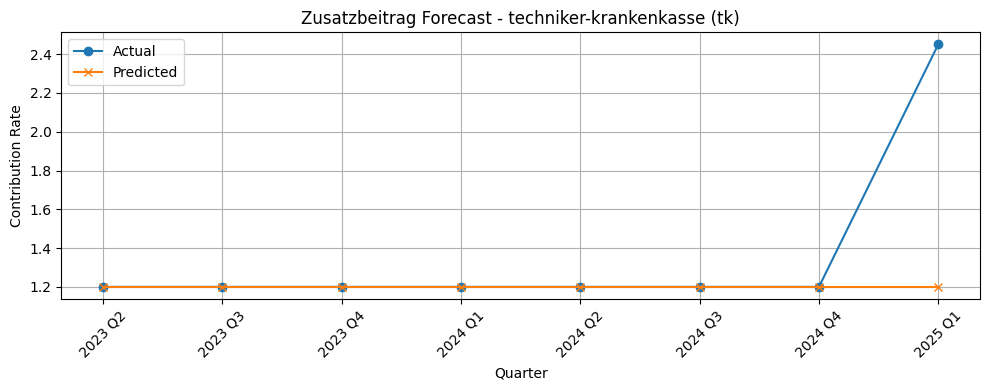

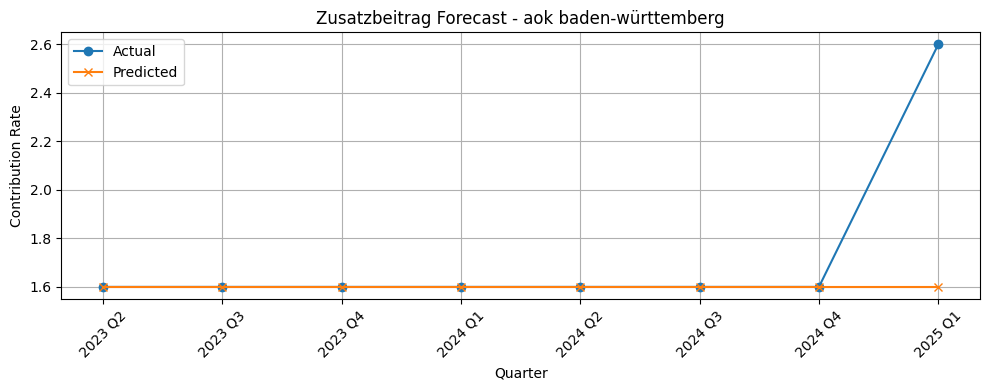

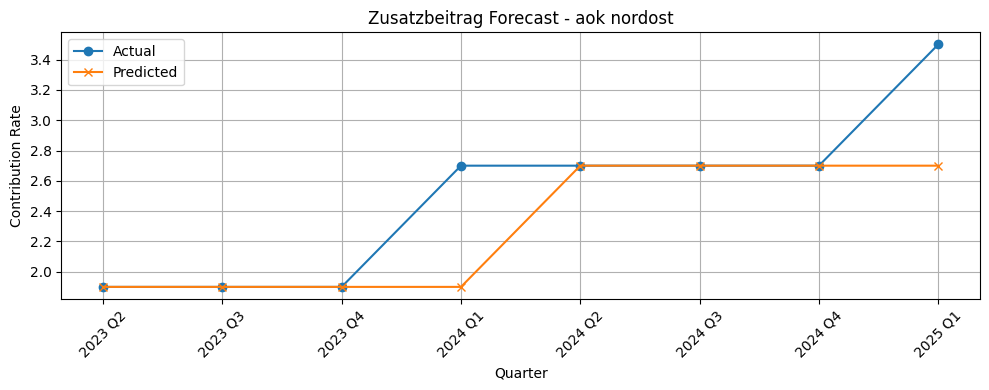

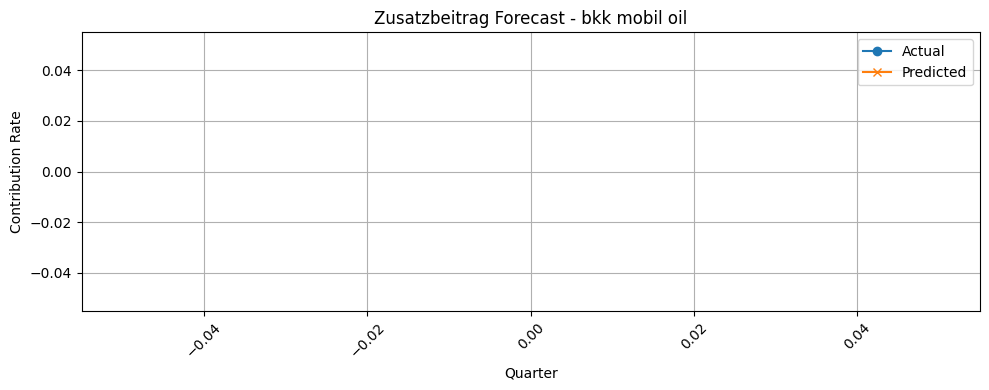

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, r2_score

# Ensure data is sorted properly
merged = merged.sort_values(['Krankenkasse', 'Jahr', 'Quartal'])

results = []

# Loop over each fund
for fund in merged['Krankenkasse'].unique():
    fund_data = merged[merged['Krankenkasse'] == fund].copy()
    fund_data = fund_data.sort_values(['Jahr', 'Quartal'])

    if len(fund_data) < 12:  # skip small samples
        continue

    test_size = 8
    train_data = fund_data.iloc[:-test_size]
    test_data = fund_data.iloc[-test_size:].copy()

    preds = []
    try:
        history = train_data['Zusatzbeitrag'].tolist()
        for i in range(test_size):
            model = ARIMA(history, order=(1, 1, 0))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=1)[0]
            preds.append(forecast)
            history.append(test_data['Zusatzbeitrag'].iloc[i])  # update with true value

        test_data['Zusatzbeitrag_pred'] = preds
        results.append(test_data)
    except Exception as e:
        print(f"ARIMA failed for {fund}: {e}")

# Combine all test forecasts
arima_results = pd.concat(results)

# Metrics
mae = mean_absolute_error(arima_results['Zusatzbeitrag'], arima_results['Zusatzbeitrag_pred'])
r2 = r2_score(arima_results['Zusatzbeitrag'], arima_results['Zusatzbeitrag_pred'])
print(f"ARIMA Last 8 Quarters MAE: {mae:.4f}")
print(f"ARIMA Last 8 Quarters R2: {r2:.4f}")

# Display output
display(arima_results[['Krankenkasse', 'Jahr', 'Quartal', 'Zusatzbeitrag', 'Zusatzbeitrag_pred']])

# Plot predictions for each fund
import matplotlib.pyplot as plt

for fund in ['techniker-krankenkasse (tk)', 'aok baden-württemberg', 'aok nordost', 'bkk mobil oil']:
    sub = arima_results[arima_results['Krankenkasse'] == fund]
    x = sub['Jahr'].astype(str) + ' Q' + sub['Quartal'].astype(str)

    plt.figure(figsize=(10, 4))
    plt.plot(x, sub['Zusatzbeitrag'], label='Actual', marker='o')
    plt.plot(x, sub['Zusatzbeitrag_pred'], label='Predicted', marker='x')
    plt.title(f'Zusatzbeitrag Forecast - {fund}')
    plt.xlabel('Quarter')
    plt.ylabel('Contribution Rate')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[1.2, 1.2, 1.2, 1.2]
[2.399998060136423, 1.1999998083516268, 1.1999999999992241, 1.199999958681544]


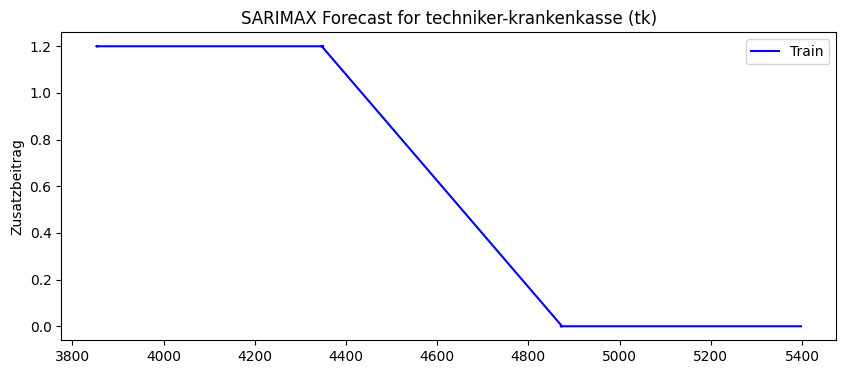

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def load_and_prepare_data():
    df = pd.read_csv("merged_data.csv")  # Replace with your path
    df = df.sort_values(['Krankenkasse', 'Jahr', 'Quartal'])
    
    # Create datetime index
    df['date'] = pd.to_datetime(df['Jahr'].astype(str) + 'Q' + df['Quartal'].astype(str))
    df.set_index('date', inplace=True)

    # Compute competitor average Zusatzbeitrag
    df['competitor_contrib'] = df.groupby(['Jahr', 'Quartal'])['Zusatzbeitrag'].transform(
        lambda x: (x.sum() - x) / (len(x) - 1)
    )

    return df

df = load_and_prepare_data()

# --- Select top 10 funds by Mitglieder ---
top_funds = df.groupby("Krankenkasse")["Mitglieder"].mean().nlargest(10).index.tolist()

# --- Streamlit UI ---
selected_fund = "techniker-krankenkasse (tk)"  # Default selection for demonstration

# --- Filter and prepare data for selected fund ---
fund_df = df[df["Krankenkasse"] == selected_fund].copy()


# --- Train-test split (last 8 quarters = test) ---
# train = fund_df.iloc[:-8]
# test = fund_df.iloc[-8:]

# --- Fit SARIMAX (with seasonal component and competitor contrib as exog) ---
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 4)  # quarterly seasonality
window_size = 12  # 3 years of quarterly data
rolling_predictions = []
actuals = []

for i in range(len(fund_data) - window_size):
    train = fund_data[i:i+window_size]
    test = fund_data.iloc[i+window_size]
    
    model = SARIMAX(train['Zusatzbeitrag'], order=(1,1,1), seasonal_order=(1,1,1,4))
    model_fit = model.fit(disp=False)
    
    forecast = model_fit.forecast(steps=1)
    rolling_predictions.append(forecast.values[0])
    actuals.append(test['Zusatzbeitrag'])

    # Evaluate
print(actuals)
print(rolling_predictions)
mae = mean_absolute_error(actuals, rolling_predictions)
r2 = r2_score(actuals, rolling_predictions)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train.index, train["Zusatzbeitrag"], label="Train", color="blue")
ax.plot(actuals.index, actuals, label="Actual", color="green")
ax.plot(rolling_predictions.index, rolling_predictions, label="Forecast", color="orange")
ax.set_title(f"SARIMAX Forecast for {selected_fund}")
ax.set_ylabel("Zusatzbeitrag")
ax.legend()


In [ ]:
from sklearn.metrics import pairwise_distances
def load_and_prepare_data() -> pd.DataFrame:
    df = pd.read_csv(/merged_data.csv')  # Replace with your path
    df = df.sort_values(['Krankenkasse', 'Jahr', 'Quartal'])
    df['date'] = pd.to_datetime(df['Jahr'].astype(str) + 'Q' + df['Quartal'].astype(str))
    df.set_index('date', inplace=True)
    df = filter_funds_with_2025_q1(df)
    df['competitor_contrib'] = compute_competitor_contrib_knn(df)
    print("competitor_contrib computed", df['competitor_contrib'])
    df = add_additional_features(df)
    return df

def filter_funds_with_2025_q1(df: pd.DataFrame) -> pd.DataFrame:
    required_quarter = pd.to_datetime("2025Q1")
    valid_funds = df[df.index == required_quarter]['Krankenkasse'].unique()
    return df[df['Krankenkasse'].isin(valid_funds)].copy()

def compute_intelligent_competitor_contrib(df: pd.DataFrame) -> pd.Series:
    def calc_competitor_avg(row, quarter_df):
        filtered = quarter_df[
            (quarter_df['Krankenkasse'] != row['Krankenkasse']) &
            (quarter_df['Zusatzbeitrag'].between(row['Zusatzbeitrag'] - 0.5, row['Zusatzbeitrag'] + 0.5))
        ]
        return filtered['Zusatzbeitrag'].mean() if not filtered.empty else np.nan

    contrib_series = pd.Series(index=df.index, dtype='float64')
    for (jahr, quartal), group in df.groupby(['Jahr', 'Quartal']):
        quarter_df = group.copy()
        contrib_series.loc[group.index] = quarter_df.apply(
            lambda row: calc_competitor_avg(row, quarter_df), axis=1
        )
    return contrib_series
def compute_competitor_contrib_knn(df: pd.DataFrame) -> pd.Series:
    df = df.copy()
    contrib_series = pd.Series(index=df.index, dtype='float64')

    # Reset index to avoid problems with duplicate index labels
    df_reset = df.reset_index()

    for (jahr, quartal), group in df_reset.groupby(['Jahr', 'Quartal']):
        group = group.reset_index(drop=True)
        features = group[['Mitglieder', 'Zusatzbeitrag']].to_numpy()

        # Compute pairwise Euclidean distances
        dists = pairwise_distances(features, metric='euclidean')
        contrib_values = np.full(len(df), np.nan)  # Create empty array
        for i, row in group.iterrows():
            # Exclude the current row from the list of competitors
            dist_to_others = dists[i].copy()
            dist_to_others[i] = np.inf  # ignore self

            # Get indices of 10 closest competitors
            top_k_indices = np.argsort(dist_to_others)[:10]
            if(len(top_k_indices) < 10):
                print(top_k_indices, row)
            # Compute mean Zusatzbeitrag of the 10 closest
            mean_contrib = group.loc[top_k_indices, 'Zusatzbeitrag'].mean()
            original_idx = group.index[i]
            contrib_values[original_idx] = mean_contrib
    return pd.Series(contrib_values, index=df.index)

def add_additional_features(df: pd.DataFrame) -> pd.DataFrame:
    df['Zusatzbeitrag_prev'] = df.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)
    df['Zusatz_diff'] = df['Zusatzbeitrag'] - df['competitor_contrib']
    df['is_start_of_year'] = (df['Quartal'] == 1).astype(int)
    return df

df = load_and_prepare_data()

FileNotFoundError: [Errno 2] No such file or directory: './ml_code/merged_data.csv'

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
def load_and_prepare_data() -> pd.DataFrame:
    df = pd.read_csv('merged_data.csv')  # Replace with your path
    df = df.sort_values(['Krankenkasse', 'Jahr', 'Quartal'])
    df['date'] = pd.to_datetime(df['Jahr'].astype(str) + 'Q' + df['Quartal'].astype(str))
    df.set_index('date', inplace=True)
    df = filter_funds_with_2025_q1(df)
    df.dropna(subset=['Zusatzbeitrag', 'Mitglieder'], inplace=True)
    df['competitor_contrib'] = compute_competitor_contrib_knn(df)
    print("competitor_contrib computed", df['competitor_contrib'])
    df = add_additional_features(df)
    return df

def filter_funds_with_2025_q1(df: pd.DataFrame) -> pd.DataFrame:
    required_quarter = pd.to_datetime("2025Q1")
    valid_funds = df[df.index == required_quarter]['Krankenkasse'].unique()
    return df[df['Krankenkasse'].isin(valid_funds)].copy()

def compute_intelligent_competitor_contrib(df: pd.DataFrame) -> pd.Series:
    def calc_competitor_avg(row, quarter_df):
        filtered = quarter_df[
            (quarter_df['Krankenkasse'] != row['Krankenkasse']) &
            (quarter_df['Zusatzbeitrag'].between(row['Zusatzbeitrag'] - 0.5, row['Zusatzbeitrag'] + 0.5))
        ]
        return filtered['Zusatzbeitrag'].mean() if not filtered.empty else np.nan

    contrib_series = pd.Series(index=df.index, dtype='float64')
    for (jahr, quartal), group in df.groupby(['Jahr', 'Quartal']):
        quarter_df = group.copy()
        contrib_series.loc[group.index] = quarter_df.apply(
            lambda row: calc_competitor_avg(row, quarter_df), axis=1
        )
    return contrib_series
def compute_competitor_contrib_knn(df: pd.DataFrame) -> pd.Series:
    df = df.copy()
    contrib_values = {}

    df_reset = df.reset_index()  # Keep original index in a column
    df_reset['_orig_index'] = df.index  # Save original index before drop=True

    for (jahr, quartal), group in df_reset.groupby(['Jahr', 'Quartal']):
        group = group.reset_index(drop=True)  # This index is temporary
        features = group[['Mitglieder', 'Zusatzbeitrag', 'Jahr', 'Quartal']].to_numpy()

        # Compute pairwise Euclidean distances
        dists = pairwise_distances(features, metric='euclidean')

        for i, row in group.iterrows():
            dist_to_others = dists[i].copy()
            dist_to_others[i] = np.inf  # ignore self

            top_k_indices = np.argsort(dist_to_others)[:10]
            mean_contrib = group.loc[top_k_indices, 'Zusatzbeitrag'].mean()

            orig_idx = row['_orig_index']
            contrib_values[orig_idx] = mean_contrib

            if row['Krankenkasse'] == 'techniker-krankenkasse (tk)':
                print(top_k_indices, row['Mitglieder'], row['Zusatzbeitrag'], mean_contrib)

    # Return as Series with proper index matching df
    contrib_series = pd.Series(contrib_values, index=df.index)
    
    # Fill any missing values with overall mean or some fallback
    contrib_series = contrib_series.fillna(df['Zusatzbeitrag'].mean())

    return contrib_series

def add_additional_features(df: pd.DataFrame) -> pd.DataFrame:
    df['Zusatzbeitrag_prev'] = df.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)
    df['Zusatz_diff'] = df['Zusatzbeitrag'] - df['competitor_contrib']
    df['is_start_of_year'] = (df['Quartal'] == 1).astype(int)
    return df

df = load_and_prepare_data()

/tmp/ipykernel_7941/1588410631.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['Jahr'].astype(str) + 'Q' + df['Quartal'].astype(str))


[61 13  1  0 70  7  9  6  4  5] 5965956 0.0 0.0
[61 13  1  0 70  7  9  6  4  5] 6048940 0.0 0.0
[61 13  1  0 70  7  9  6  4  5] 6133353 0.0 0.0
[61 13  1  0 70  7  9  6  4 75] 6248736 0.0 0.0
[13 61  1  0 70  7  9  6  4 75] 6319407 0.0 0.0
[13 61  1  0 70  7  9  6  4 75] 6419030 0.0 0.0
[13 61  1  0 70  7  9  6  4 75] 6511810 0.0 0.0
[13 61  1  0 70  7  9  6  4 75] 6639532 0.0 0.0
[13 61  1  0 70  7  9  6  4 75] 6721642 0.8 0.8099999999999999
[13 61  1  0 70  7  9  6  4 75] 6809575 0.8 0.8099999999999999
[13 61  1  0 70  7  9  6  4 75] 6867467 0.8 0.8099999999999999
[13 61  1  0 70  7  9  6  4 75] 6976235 0.8 0.8099999999999999
[13 61  1  0 70  7  9  6  4  5] 7044467 1.0 1.06
[13 61  1  0 70  7  9  6  4  5] 7156419 1.0 1.06
[13 61  1  0 70  7  9  6  4  5] 7208631 1.0 1.06
[13 61  1  0 70  7  9  6  4  5] 7296182 1.0 1.06
[13 61  1  0  7 70  9  6  4  5] 7342157 1.0 1.09
[13 61  1  0  7 70  9  6  4  5] 7405340 1.0 1.09
[13 61  1  0  7 70  9  6  4  5] 7450153 1.0 1.09
[13 61  1  0  7 70  9

In [ ]:
df[df["Krankenkasse"] == "aok"].tail(10)

,Jahr,Krankenkasse,Quartal,Mitglieder,Versicherte,Zusatzbeitrag,Risikofaktor,Marktanteil Mitglieder,Marktanteil Versicherte,members_prev,churn_abs,churn_rel,Zusatzbeitrag_prev,rate_change,competitor_contrib,Zusatz_diff,is_start_of_year
date,,,,,,,,,,,,,,,,,
2022-10-01,2022,techniker-krankenkasse (tk),4,8491240,11033470,1.20,NaN,NaN,NaN,8423145.0,68095.0,0.808427,1.2,0.00,1.182,0.018,0
2023-01-01,2023,techniker-krankenkasse (tk),1,8528207,11082739,1.20,NaN,NaN,NaN,8491240.0,36967.0,0.435355,1.2,0.00,1.365,-0.165,1
2023-04-01,2023,techniker-krankenkasse (tk),2,8590076,11166136,1.20,NaN,NaN,NaN,8528207.0,61869.0,0.725463,1.2,0.00,1.365,-0.165,0
2023-07-01,2023,techniker-krankenkasse (tk),3,8645781,11237484,1.20,NaN,NaN,NaN,8590076.0,55705.0,0.648481,1.2,0.00,1.365,-0.165,0
2023-10-01,2023,techniker-krankenkasse (tk),4,8717470,11283414,1.20,NaN,NaN,NaN,8645781.0,71689.0,0.829179,1.2,0.00,1.417,-0.217,0
2024-01-01,2024,techniker-krankenkasse (tk),1,8760843,11333410,1.20,NaN,NaN,NaN,8717470.0,43373.0,0.497541,1.2,0.00,1.523,-0.323,1
2024-04-01,2024,techniker-krankenkasse (tk),2,8922850,11543045,1.20,NaN,NaN,NaN,8760843.0,162007.0,1.849217,1.2,0.00,1.574,-0.374,0
2024-07-01,2024,techniker-krankenkasse (tk),3,9000824,11644323,1.20,NaN,NaN,NaN,8922850.0,77974.0,0.873869,1.2,0.00,1.604,-0.404,0
2024-10-01,2024,techniker-krankenkasse (tk),4,9091128,11711810,1.20,NaN,NaN,NaN,9000824.0,90304.0,1.003286,1.2,0.00,1.954,-0.754,0


In [6]:

features = ['Zusatzbeitrag', 'competitor_contrib', 'Zusatzbeitrag_prev']
X = df[features]
y = df['churn_rel']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
models = {
    "HistGradientBoosting": HistGradientBoostingRegressor(
        l2_regularization=0,
        learning_rate=0.05,
        max_depth=7,
        max_iter=100
    ),
    "LGBMRegressor": LGBMRegressor(),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1),
}
# Train models
for name, model in models.items():
    model.fit(X_train, y_train)
    df[f'predicted_churn_{name}'] = model.predict(df[features])


NameError: name 'train_test_split' is not defined

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

features = ['Zusatzbeitrag', 'competitor_contrib']
X = df[features]
y = df['churn_rel']
df.dropna(subset=features + ['churn_rel'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Split & scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Top 5 models based on your table
models = {
    "HistGradientBoosting": HistGradientBoostingRegressor(        
        l2_regularization=0,
        learning_rate=0.05,
        max_depth=7,
        max_iter=100

),
    "LGBMRegressor": LGBMRegressor(),  # Replace with LGBMRegressor if LightGBM is installed
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1),
    "RandomForest": RandomForestRegressor(),
    "MLPRegressor": MLPRegressor(max_iter=1000)
}

results = []

# Evaluation loop
for name, model in models.items():
    print(f"Training {name}...")
    if name == "HistGradientBoosting":
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        cv_rmse = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5).mean()
    else:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        cv_rmse = -cross_val_score(model, scaler.transform(X), y, scoring='neg_root_mean_squared_error', cv=5).mean()

    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "RMSE": round(rmse, 3),
        "R²": round(r2, 3),
        "CV RMSE": round(cv_rmse, 3)
    })

    # # Plot actual vs predicted
    # plt.figure(figsize=(6, 4))
    # plt.scatter(y_test, preds, alpha=0.5)
    # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    # plt.xlabel("Actual")
    # plt.ylabel("Predicted")
    # plt.title(f"{name}: Actual vs Predicted")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

# Results table
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="RMSE")
print("\nModel Evaluation Summary:")
print(df_results.to_markdown(index=False))


Training HistGradientBoosting...


/home/hamzaraza/uni_work/sem_1/Data Science/data_science_project/data_science_project/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training LGBMRegressor...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 3609, number of used features: 2
[LightGBM] [Info] Start training from score 0.565649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 3609, number of used features: 2
[LightGBM] [Info] Start training from score 0.607056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 3609, number of used features: 2
[LightGBM]

/home/hamzaraza/uni_work/sem_1/Data Science/data_science_project/data_science_project/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training GradientBoosting...


/home/hamzaraza/uni_work/sem_1/Data Science/data_science_project/data_science_project/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training RandomForest...


/home/hamzaraza/uni_work/sem_1/Data Science/data_science_project/data_science_project/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Training MLPRegressor...

Model Evaluation Summary:
| Model                |   RMSE |     R² |   CV RMSE |
|:---------------------|-------:|-------:|----------:|
| HistGradientBoosting |  4.723 |  0.023 |     3.274 |
| LGBMRegressor        |  4.727 |  0.022 |     3.285 |
| MLPRegressor         |  4.746 |  0.014 |     3.26  |
| RandomForest         |  4.751 |  0.012 |     3.354 |
| GradientBoosting     |  4.78  | -0     |     3.375 |


/home/hamzaraza/uni_work/sem_1/Data Science/data_science_project/data_science_project/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
features = ['Zusatzbeitrag', 'competitor_contrib', 'Zusatzbeitrag_prev']
X = df[features]
y = df['churn_rel']
df.dropna(subset=features + ['churn_rel'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


(0, 0)